<a href="https://colab.research.google.com/github/SaionaraAraujo/Dominando-Data-Science-Flai/blob/main/%20Dominando-Data-Science-Flai/Machine%20Learning/Arvore-Decis%C3%A3o/%C3%81rvore_de_Decis%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prevendo custos de plano de Saúde com Árvore de Decisão

##Introdução

A ciência de dados vem ajudando a analisar dados com foco em descobrir (ou tentar) o que poderá acontecer no futuro. No caso de exemplo que vamos estudar, não será diferente. Vamos prever os custos de um plano de saúde com base em alguns dados já registrados.

##Modelo de ML Árvore de Decisão para Regressão

Este modelo faz parte da família de modelos de aprendizado supervisionado, usado para prever um resultado ou tomar uma decisão com base em um conjunto de condições. Na estrutura do modelo de árvore, cada nó representa uma condição ou atributo, e cada ramo representa uma escolha possível ou um resultado.

A árvore começa com um nó raiz, que representa todos os dados analisados. Em seguida, os ramos se dividem em diferentes condições ou atributos, criando caminhos possíveis para seguir na árvore. Cada nó de folha, ou final, representa um resultado possível ou decisão baseada nas condições encontradas ao longo do caminho.

O desenvolvimento do modelo envolve a seleção de um atributo para cada nó, com base em sua capacidade de separar os dados de acordo com as classes desejadas. Para garantir a qualidade da separação, o modelo usa um critério de impureza, como a entropia, para medir o grau de desordem dos dados.

> Para entender melhor, vamos considerar um guarda-roupa completamente bagunçado. Nesse caso, o grau de entropia seria muito alto. Mas podemos organizar as roupas por cor ou por tipo, reduzindo o grau de desordem. Na árvore de decisão, o modelo decidiria qual método traria um menor grau de entropia.

Esse modelo é muito popular em aprendizado de máquina, pois é simples e de fácil interpretação. Pode ser aplicado tanto na regressão quanto na classificação, em diversos problemas de negócios. No caso deste estudo, usaremos o modelo em um problema de regressão.

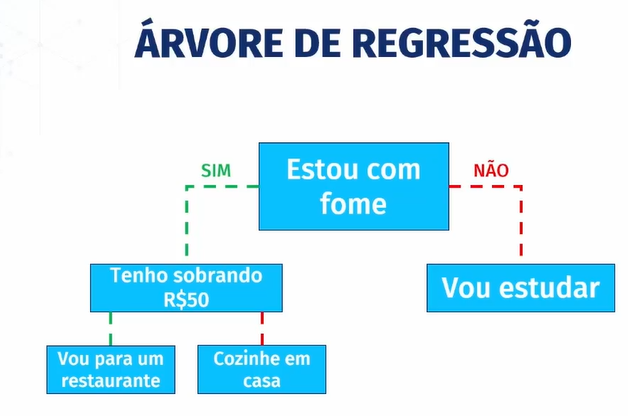

##Construção do Modelo

###Preprando o ambiente

In [1]:
import pandas as pd

#Carregando os dados
dados = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


###Conhecendo os dados

A seguir, vamos saber o tamanho do conjuntos de dados em linhas e colunas.

In [2]:
linhas, colunas = dados.shape
print('Linhas: ',linhas)
print('Colunas: ', colunas)

Linhas:  1338
Colunas:  7


É preciso entender também os tipos de dados presentes no conjunto:

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


É um conjunto relativamente pequeno, mas suficiente para nos ajudar a compreender o modelo de árvore de decisão. A maior parte das colunas trazem dados numéricos, mas já dando um spoiler, precisaremos ajustar a variável `smoker`, que será usada no modelo, mas que está como string.

 Agora vamos entender algumas características estatísticas dos dados:

In [4]:
#Análise estatística dos dados
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Alguns pontos que descobrimos:
* A idade varia entre 18 e 64 anos, com média de aproximadamente 39 anos;

* A quantidade de filhos é no máximo 5, mas a média é 1;

* Quanto aos custos, nesse conjunto varia entre, aproximadamente, U$ 1.121,00 dólares e U$ 63.770 doláres. Mas a mediana, que indica o limite da metade dos dados, é de U$ 9382,00 um valor muito distante do máximo dos dados;

* O desvio padrão, medida que mostra o quão dispersos estão os dados em volta da média, é um valor alto em relação a média, U$12.110,00. Para essa variável, que será muito utilizada, vamos analisar se os dados estão distribuídos normalmente.


<Axes: >

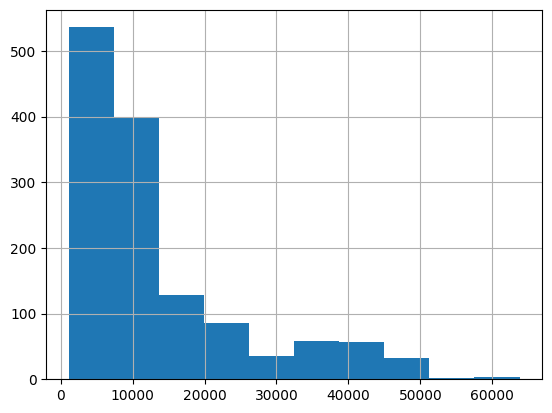

In [5]:
dados['charges'].hist()

Podemos ver que eles não estão em uma distribuição nem próxima da normal, o que pode dificultar a funcionalidade do modelo, dependendo de como os dados serão utilizados, tornando necessário um tratamento especial. No nosso caso, não precisaremos, mas este foi um ponto de atenção para sempre ficarmos atentos a essa característica.

Agora que conhecemos um pouco dos dados, podemos então passar para a construção do modelo.

##Ajustar os dados para o modelo de ML

Sabemos que para modelos de machine learning, os dados precisam ser todos numéricos e estar em escalas parecidas. Vamos fazer estes ajustes a seguir:

* Transfomar a variável `smoker`em uma variável numérica - aqui usaremos o método `map()`, que pede um dicionário composto por chave, trazendo o valor atual, e valores, que são compostos pelos valores desejados;

* Reduzir a escala do valor do custo: esta variável está na casa dos U$1.000,00. Vamos reduzir para facilitar os cálculos do modelo, e pra este trabalho, utilizaremos o valor dividido por 1000;

* Como vamos analisar apenas 3 variáveis (`smoker`, `bmi`e `charges`) vamos reduzir o conjunto a estas 3 colunas

In [6]:
#Deixar a variável numérica
dados['smoker'] = dados['smoker'].map({'yes':1, 'no':0})

#Reduzir a escala:
dados['charges'] = dados['charges']/1000

#Reduzir os dados para apenas 3 colunas
dados = dados[['bmi', 'smoker', 'charges']]

dados.head()

,bmi,smoker,charges
0,27.900,1,16.884924
1,33.770,0,1.725552
2,33.000,0,4.449462
3,22.705,0,21.984471
4,28.880,0,3.866855


##Modelo escolhido: **Árvore de Decisão**

Para todo e qualquer problema que vamos resolver com machine learning, precisamos de 3 pilares:
* Um modelo - com o qual analisaremos os dados;
* Uma métrica - para verificar a qualidade do modelo escolhido; e
* Validação - precisamos analisar como nosso modelo se comporta com dados novos, não apresentados no momento do treino.

A seguir, vamos criar um algoritmo que tem os seguintes passos:
* Importar modelo, métrica e validação;
* Definir o tamanho da árvore (a profundidade);
* Escolher quantas vezes vamos executar o modelo para gerar métricas mais estáveis;
* Selecionar as variáveis preditoras e resposta; e
* Executar o modelo numa repetição na quantidade de vezes escolhidas.

Além disso, vamos analisar as métricas tanto para o conjunto de dados de treino e de teste com o objetivo de entender se estamos genrando overfitting, construindo um modelo altamente específico, ou não.

In [7]:
from sklearn.tree import DecisionTreeRegressor #Modelo
from sklearn.metrics import mean_squared_error #Métrica
from sklearn.model_selection import train_test_split #Validacao
import numpy as np

#Profundidade da árvore
profundidade = 1

#Repetições do modelo
R =100

#Guardar os valores das métricas
eqms_treino = []
eqms_teste = []

#Variáveis analisadas
X = dados[['bmi']] #Preditora
y = dados['charges'] #Resposta


for i in range(R):
  #Separar os dados em conjuntos de treino e teste, considerando 25% dos dados para teste
  Xtreino, Xteste, ytreino, yteste = train_test_split(X, y, test_size= 0.25)

  #Definindo o modelo, com a profundidade que escolhemos
  arvore = DecisionTreeRegressor(max_depth= profundidade)
  #Treinando o modelo
  arvore.fit(Xtreino, ytreino)

  
  #Testa o modelo no dados de treino
  preditos_treino = arvore.predict(Xtreino)
  #Guardando a métrica da predição para os dados de treino
  eqms_treino.append(mean_squared_error(preditos_treino,ytreino))

  #Testa o modelo no dados de teste
  preditos_teste = arvore.predict(Xteste)
  #Guardando a métrica da predição para os dados de teste
  eqms_teste.append(mean_squared_error(preditos_teste,yteste))

print('EQM Treino: ', np.mean(eqms_treino).round(1))
print('EQM Teste: ', np.mean(eqms_teste).round(1))



EQM Treino:  139.9
EQM Teste:  143.3


Observando a diferença entre os EQMs, caso o de teste seja muito maior que o de treino, pode indicar que o modelo foi treinado de modo a prever resultados muito específicos e não tenha um bom desempenho ao avaliar novos dados, **podendo gerar previsões de custos não tão boas**.

Mas é importante lembrar que esse método separa os dados de treino e teste de forma aleatória, e por isso fazemos de forma repetida. Por isso é importante considerar que os valores da métrica podem variar, logo o importante é entender o conceito. 

###Gráfico com 1 variável preditora

Depois de executar o modelo, vamos tentar vizualizar graficamente o resultado.

Vamos analisar graficamente como o modelo gera uma árvore com uma variável preditora.

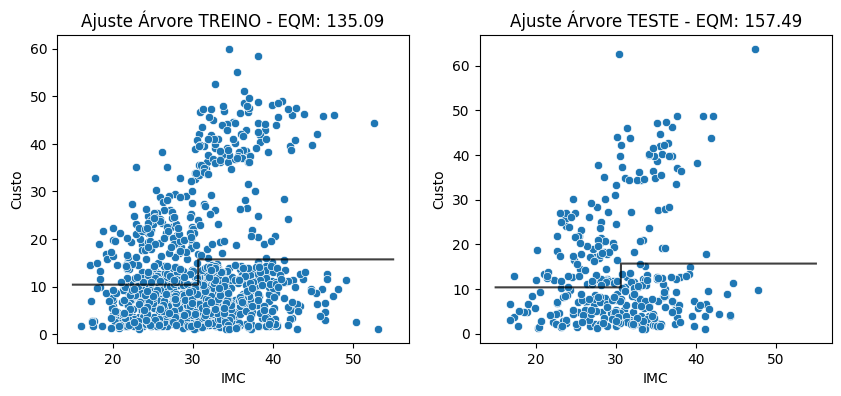

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

#Variáveis analisadas
X = dados[['bmi']] #Preditora
y = dados['charges'] #Resposta

#Separar os dados em conjuntos de treino e teste, considerando 25% dos dados para teste
Xtreino, Xteste, ytreino, yteste  = train_test_split(X, y, test_size = 0.25)

#Definindo o modelo, com a profundidade que escolhemos
arvore = DecisionTreeRegressor(max_depth = profundidade)
#Treinando o modelo
arvore.fit(Xtreino, ytreino)

#Testa o modelo em dados novos
preditos_treino = arvore.predict(Xtreino)
preditos_teste = arvore.predict(Xteste)

#Guardando a métrica da predição para os dados de teste
eqm_treino = mean_squared_error(preditos_treino, ytreino)
eqm_teste = mean_squared_error(preditos_teste, yteste) 

import numpy as np

#Gerando os pontos do gráfico
x = np.arange(15, 55, 0.01)

#Predição com novos dados
y = arvore.predict(pd.DataFrame({'bmi': x}))


#Gráfico
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x = Xtreino['bmi'], y = ytreino)
plt.plot(x, y, color = 'black', alpha = 0.75)
plt.title('Ajuste Árvore TREINO - EQM: ' + str(round(eqm_treino, 2)))
plt.xlabel('IMC')
plt.ylabel('Custo')  

plt.subplot(1, 2, 2)
sns.scatterplot(x = Xteste['bmi'], y = yteste)
plt.plot(x, y, color = 'black', alpha = 0.75)
plt.title('Ajuste Árvore TESTE - EQM: ' + str(round(eqm_teste, 2)))
plt.xlabel('IMC')
plt.ylabel('Custo') 
plt.show()

Repare que a representação gráfica do modelo consiste em uma "escada" que vai sendo plotada sempre em paralelo aos eixos. A quantidade de "degraus" é exatamente a profundidade que determinamos.

Agora, em relação ao nosso problema de negócio, o que podemos perceber neste gráfico? Essas linhas representam os "cortes" nos dados, de acordo com a execução do modelo. Por exemplo, para pessoas com IMC de aproximadamente 30, o modelo calcula que há um novo padrão de valor de custo. Esse comportamento acompanha o comportamento dos dados, que começam a representar custos maiores a partir deste ponto. É importante notar que a representação gráfica do modelo pode ajudar a entender a relação entre as variáveis e a fazer previsões mais precisas.

Agora vamos ver o comportamento do modelo com 2 variáveis.

###Gráfico com 2 variáveis preditoras

Ao explicar algo para alguém, quanto mais detalhes utilizamos, mais fácil o ouvinte entenderá do que se trata. Não é diferente com os modelos de ML. Por isso, vamos analisar as métricas do modelo com duas variáveis e verificar graficamente como os valores podem ser previstos no gráfico.

A seguir, vamos analisar o gráfico.

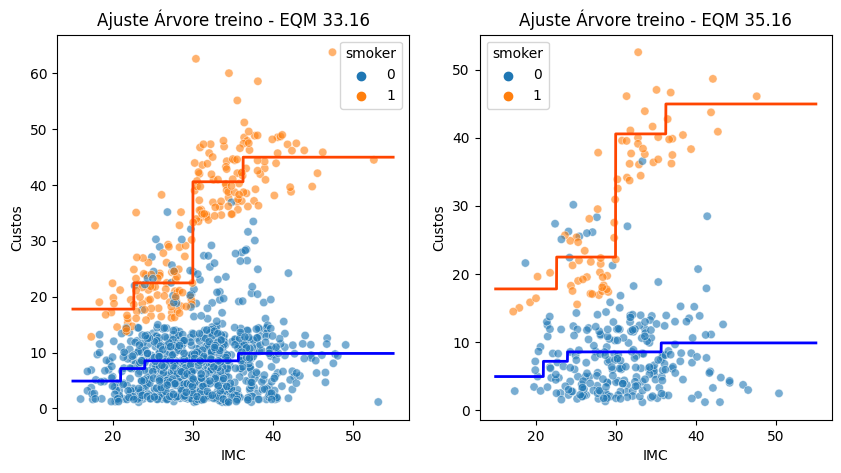

In [9]:
#Variáveis analisadas
X = dados[['bmi', 'smoker']] #Variáveis preditoras
y = dados['charges'] #Variável Resposta

#Separar os dados em conjuntos de treino e teste, considerando 25% dos dados para teste
Xtreino, Xteste, ytreino, yteste = train_test_split(X, y, test_size= 0.25)

#Definindo o modelo, com a profundidade que escolhemos
modelo = DecisionTreeRegressor(max_depth= 3)
#Treinando o modelo
modelo.fit(Xtreino, ytreino)

#Predição com dados de treino
preditos_treino = modelo.predict(Xtreino)
preditos_teste = modelo.predict(Xteste)

#Guardando a métrica da predição para os dados de teste
eqm_treino = mean_squared_error(preditos_treino,ytreino)
eqm_teste = mean_squared_error(preditos_teste,yteste)

#Gerando os pontos do gráfico
x1 = np.arange(15,55,0.01)

#Pontos para a variável smoker, que pode assumir os valores 0 ou 1
v0 = np.zeros(len(x1))
v1 = np.ones(len(x1))

#Novos dados para avaliar o modelo na predição
c0 = pd.DataFrame([x1,v0], index = ['bmi', 'smoker']).T
c1 = pd.DataFrame([x1,v1], index = ['bmi', 'smoker']).T

#Predição com os novos dados
d0 = modelo.predict(c0)
d1 = modelo.predict(c1)

#Gráficos
plt.figure(figsize = (10,5)) 

plt.subplot(1,2,1)
sns.scatterplot(x = Xtreino['bmi'], y = ytreino, hue = Xtreino['smoker'], alpha = 0.6)
plt.plot(x1, d0,'-', color = 'blue', linewidth = 2 )
plt.plot(x1, d1,'-', color = 'orangered', linewidth = 2 )
plt.title('Ajuste Árvore treino - EQM '+ str(round(eqm_treino,2)))
plt.xlabel('IMC')
plt.ylabel('Custos')

plt.subplot(1,2,2)
sns.scatterplot(x = Xteste['bmi'], y = yteste, hue = Xteste['smoker'], alpha = 0.6)
plt.plot(x1, d0,'-', color = 'blue', linewidth = 2 )
plt.plot(x1, d1,'-', color = 'orangered', linewidth = 2 )
plt.title('Ajuste Árvore treino - EQM ' + str(round(eqm_teste,2)))
plt.xlabel('IMC')
plt.ylabel('Custos')
plt.show()

Agora podemos percer a difença dos dados de fumantes (`smoker`= 1) e não fumantes (`smoker`= 0) e os "cortes" nos dados, conforme a produndidade definida. Podemos ver que para esta visão dos dados, os dois grupos são em divididos e parecem estar bem abarcados pelas retas. 

O que isso significa? Que o modelo consegue prever melhor os valores, ao acrescentar uma nova variável. Podemos perceber que, para fumantes, com IMC de valor de 30, há um aumento significativo no alor do custo. Comportamento que também é claro nos dados de teste.

Podemos melhorar essa visualização, utilizando uma biblioteca própria para construir gráficos de árvore.

###Gráfico de Árvore

A biblioteca plot_tree é uma ferramenta que permite visualizar a estrutura de uma árvore de decisão. É uma funcionalidade oferecida pela biblioteca scikit-learn em Python.

Através da plot_tree, é possível obter uma representação gráfica da árvore de decisão, mostrando as decisões tomadas em cada nó e como as variáveis influenciam as decisões finais. Essa visualização pode ser muito útil para interpretar e entender melhor o modelo de árvore de decisão.

Para utilizar a plot_tree, é necessário importá-la da biblioteca scikit-learn e então aplicá-la ao modelo de árvore de decisão que foi treinado. A partir daí, é possível personalizar a visualização com diferentes parâmetros, como tamanho, cor e estilo das setas.

Alguns exemplos de parâmetros que podem ser utilizados na plot_tree são:

* max_depth: limita a profundidade da árvore que será plotada
* impurity: indica a medida de impureza usada para dividir os nós
* filled: define se os nós serão preenchidos com cores ou não

Com a plot_tree, é possível entender de forma mais clara como as decisões são tomadas dentro de um modelo de árvore de decisão e, assim, fazer ajustes para melhorar o desempenho do modelo.

Vamos ver na prática:

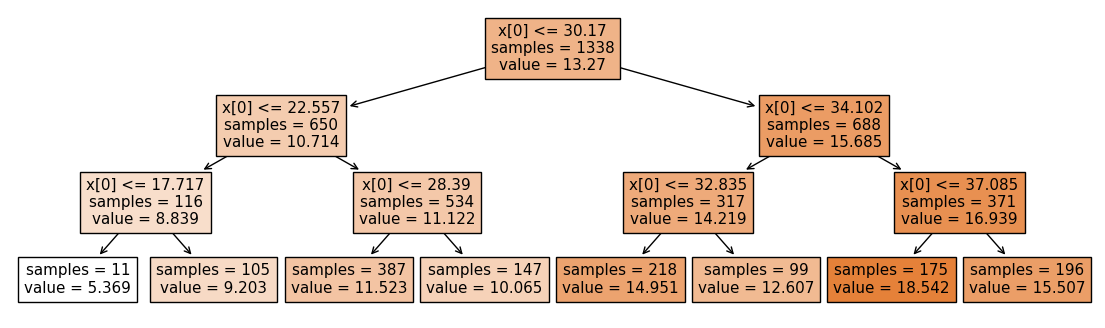

In [19]:
#Grafico da Árvore
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

#Dados
X = dados[['bmi']]
y = dados['charges']

#Modelo
arvore = DecisionTreeRegressor(max_depth = 3, min_samples_split = 50)
arvore.fit(X, y)

#Gráfico
plt.figure(figsize = (14, 4))
plot_tree(arvore, filled=True, proportion = False, impurity = False)
plt.show()

No gráfico gerado, podemos ver de forma mais clara a divisão dos dados conforme os nós da árvore vão sendo constuídos.

No nó raiz, temos todos os dados do grupo de treino, descritos no parâmetro `samples`, cujo valor de custo(`value`) é 13.27, cujo o IMC é de até 30.17. 
A próxima divisão divide os dados em dois grupos baseado no IMC. Um grupo com IMC de até 22.557, custo de 10.714 e 650 registros, e o outro grupo cujo IMC é de até 34.102, com 688 amostras e custo previsto de 15.685. 

Assim, os grupos vão sendo defindos pelo modelo até que os parâmetros de parada sejam atingidos. Estas condições podem ser definidas no momento da execução do modelo, sendo a profundidedade (`max_depht`) ou o tamanho minímo do grupo (`min_samples_split`).

Neste modelo, utilizamos apenas o IMC como variável preditora, a X[0]. Vamos analisar o modelo com duas variáveis.

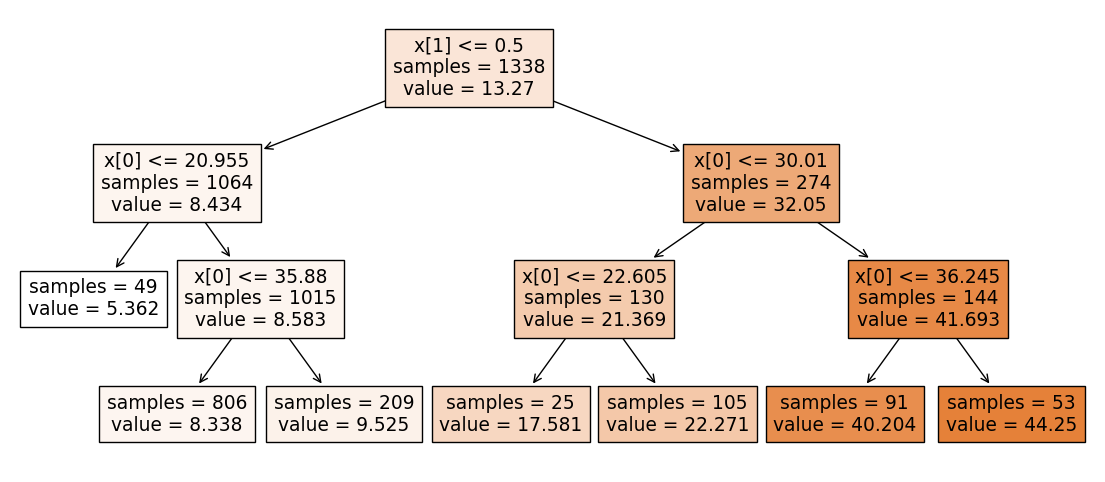

In [18]:
#Grafico da Árvore com 2 variáveis
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

#Dados
X = dados[['bmi','smoker']]
y = dados['charges']

#Modelo
arvore = DecisionTreeRegressor(max_depth = 3, min_samples_split = 50)
arvore.fit(X, y)

#Gráfico
plt.figure(figsize = (14, 6))
plot_tree(arvore, filled=True, proportion = False, impurity = False)
plt.show()

Agora a variável que divide os dados é a `smoker`, a x[1]. Os segundos nós consideram o IMC para fazer as divisões, maas fica subentendido o valor da `smoker`. Por exemplo, No nó abaixo do primeiro, cujo tamanho da amostra é 1064, considera os não fumantes, visto que está do lado dos grupos onde x[1] é de até 0.5, logo não chega em 1, que representa os fumantes. 

##Conclusão

A árvore de decisão para regressão é uma técnica poderosa e útil na ciência de dados, permitindo modelar e prever valores contínuos a partir de variáveis explicativas. A árvore é construída a partir de uma série de decisões que dividem os dados em subconjuntos cada vez menores, até que sejam geradas folhas que contêm as previsões para cada subconjunto.

Uma das principais vantagens dessa técnica é a sua interpretabilidade, permitindo que as decisões tomadas pelo modelo possam ser facilmente entendidas e justificadas. Além disso, a árvore de decisão pode ser facilmente visualizada e ajustada, permitindo uma otimização do modelo para melhor se adequar aos dados.

Por outro lado, a árvore de decisão pode ser suscetível a overfitting, especialmente se a profundidade da árvore não for devidamente ajustada ou se houver uma quantidade excessiva de variáveis explicativas. Além disso, a árvore pode ser sensível a outliers e dados ruidosos, o que pode levar a previsões imprecisas.

Em resumo, a árvore de decisão para regressão é uma técnica valiosa na caixa de ferramentas de um cientista de dados, mas deve ser utilizada com cuidado e com uma compreensão completa de suas vantagens e limitações.


---

Para o nosso problema de negócio, com a árvore de decisão aplicada para regressão, foi possível entender mais facilmente como os dados são interpretados no modelo. Com esse material, seria possível mostrar para uma pessoa de outra área, como os custos são previstos, facilitando a compreensão e agilizando a etapa de entendimento do modelo. 

Como trabalho futuro, o modelo deve estar em produção para ser exposto a dados nunca vistos, buscando auxiliar os planos de saúde com novos casos. Além disso, pode ser treinado com mais variáveis e mais variações da árvore, até que se chegue em um modelo adequado para a realidade, considerando a métrica de validação utilizada aqui, o EQM.